# COCO Dataset
### Link: https://cocodataset.org/#home

In [1]:
import json
import random
random.seed(1234)

# Load COCO datasets
with open('/Users/chen/DSAN6600-Project/coco2017/annotations/instances_train2017.json', 'r') as file:
    annotations_data = json.load(file)
with open('/Users/chen/DSAN6600-Project/coco2017/annotations/captions_train2017.json', 'r') as file:
    captions_data = json.load(file)

# Filter for images with category_id = 1 which is person images
image_ids = {anno['image_id'] for anno in annotations_data['annotations'] if anno['category_id'] == 1}

# Extract captions and image IDs
captions_with_ids = [{'caption': cap['caption'], 'image_id': cap['image_id']} 
                     for cap in captions_data['annotations'] if cap['image_id'] in image_ids]

# Randomly select 10,000 captions 
selected_data = random.sample(captions_with_ids, min(10000, len(captions_with_ids)))

# Save the selected data
with open('selected_data_10000.json', 'w') as file:
    json.dump(selected_data, file)

selected_data


[{'caption': 'A man wearing earphones doing a trick on a skateboard ramp.',
  'image_id': 568872},
 {'caption': 'There is a surfer wearing a body suit riding a wave',
  'image_id': 304252},
 {'caption': 'The teenagers are standing together on the sidewalk. ',
  'image_id': 539124},
 {'caption': 'A person jumping off a ramp with their snowboard. ',
  'image_id': 225299},
 {'caption': 'Two tennis players play a game while a crowd watches.',
  'image_id': 490875},
 {'caption': 'A laptop next to a book opened on a floor.', 'image_id': 257629},
 {'caption': 'A person riding a horse on a city street near buildings.',
  'image_id': 156834},
 {'caption': 'a small boy in an orange shirt a baseball glove and ball',
  'image_id': 26907},
 {'caption': 'A lot of people that are riding some horses.',
  'image_id': 94569},
 {'caption': 'A chocolate cake that has a small house and some animals on it.',
  'image_id': 54260},
 {'caption': 'The plane  is inflatable  and cows ', 'image_id': 504101},
 {'ca

In [2]:
import os
import shutil
import json

coco_images_directory = '/Users/chen/DSAN6600-Project/coco2017/train2017'

# To save images
save_images = '/Users/chen/Desktop/new/Images'
if not os.path.exists(save_images):
    os.makedirs(save_images)

# Load the selected data
with open('selected_data_10000.json', 'r') as file:
    selected_data = json.load(file)

for item in selected_data:
    image_id = item['image_id']
    image_filename = f'{str(image_id).zfill(12)}.jpg'
    source_path = os.path.join(coco_images_directory, image_filename)
    target_path = os.path.join(save_images, image_filename)
    shutil.copy(source_path, target_path)


In [3]:
from PIL import Image
import torchvision.transforms as transforms
import nltk
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from typing import List
# from pynvml import *
import pandas as pd
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
from tqdm import tqdm

random.seed(1234)


/Users/chen/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-29 01:47:14.245712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Define the path prefix for the images
image_path_prefix = "./Images"

# Load data from the JSON file
with open('./selected_data_10000.json', 'r') as json_file:
    data = json.load(json_file)

image_paths = []
captions = []

# Create image paths and captions using a loop
for item in data:
    image_id = item["image_id"]
    img_name = '%012d.jpg' % image_id
    image_path = f"{img_name}"
    caption = item["caption"]

    image_paths.append(image_path)
    captions.append(caption)

df = pd.DataFrame({'image': image_paths, 'caption': captions})
df.head(5)

image                                            caption
0  000000568872.jpg  A man wearing earphones doing a trick on a ska...
1  000000304252.jpg  There is a surfer wearing a body suit riding a...
2  000000539124.jpg  The teenagers are standing together on the sid...
3  000000225299.jpg  A person jumping off a ramp with their snowboa...
4  000000490875.jpg  Two tennis players play a game while a crowd w...

In [5]:
# Convert the DataFrame to a string, including the headers
formatted_text = df.to_csv(sep=',', index=False)

# Save to text file with headers
with open('coco_caption.txt', 'w') as file:
    file.write(formatted_text)



In [10]:
image_path = './Images'
data = pd.read_csv("./coco_caption.txt")
data.head()

image                                            caption
0  000000568872.jpg  A man wearing earphones doing a trick on a ska...
1  000000304252.jpg  There is a surfer wearing a body suit riding a...
2  000000539124.jpg  The teenagers are standing together on the sid...
3  000000225299.jpg  A person jumping off a ramp with their snowboa...
4  000000490875.jpg  Two tennis players play a game while a crowd w...

In [7]:
def load_captions(filename):
    df = pd.read_csv(filename)
    return df


captions_file = "./coco_caption.txt" 
captions_data = load_captions(captions_file)

all_texts = captions_data['caption'].tolist()
all_imgs = captions_data['image'].tolist()
for i in range(len(all_imgs)):
    all_imgs[i] = "./Images/"+all_imgs[i]

In [8]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),              
        transforms.CenterCrop(224),          
        transforms.ToTensor(),                
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image)

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    return tokens

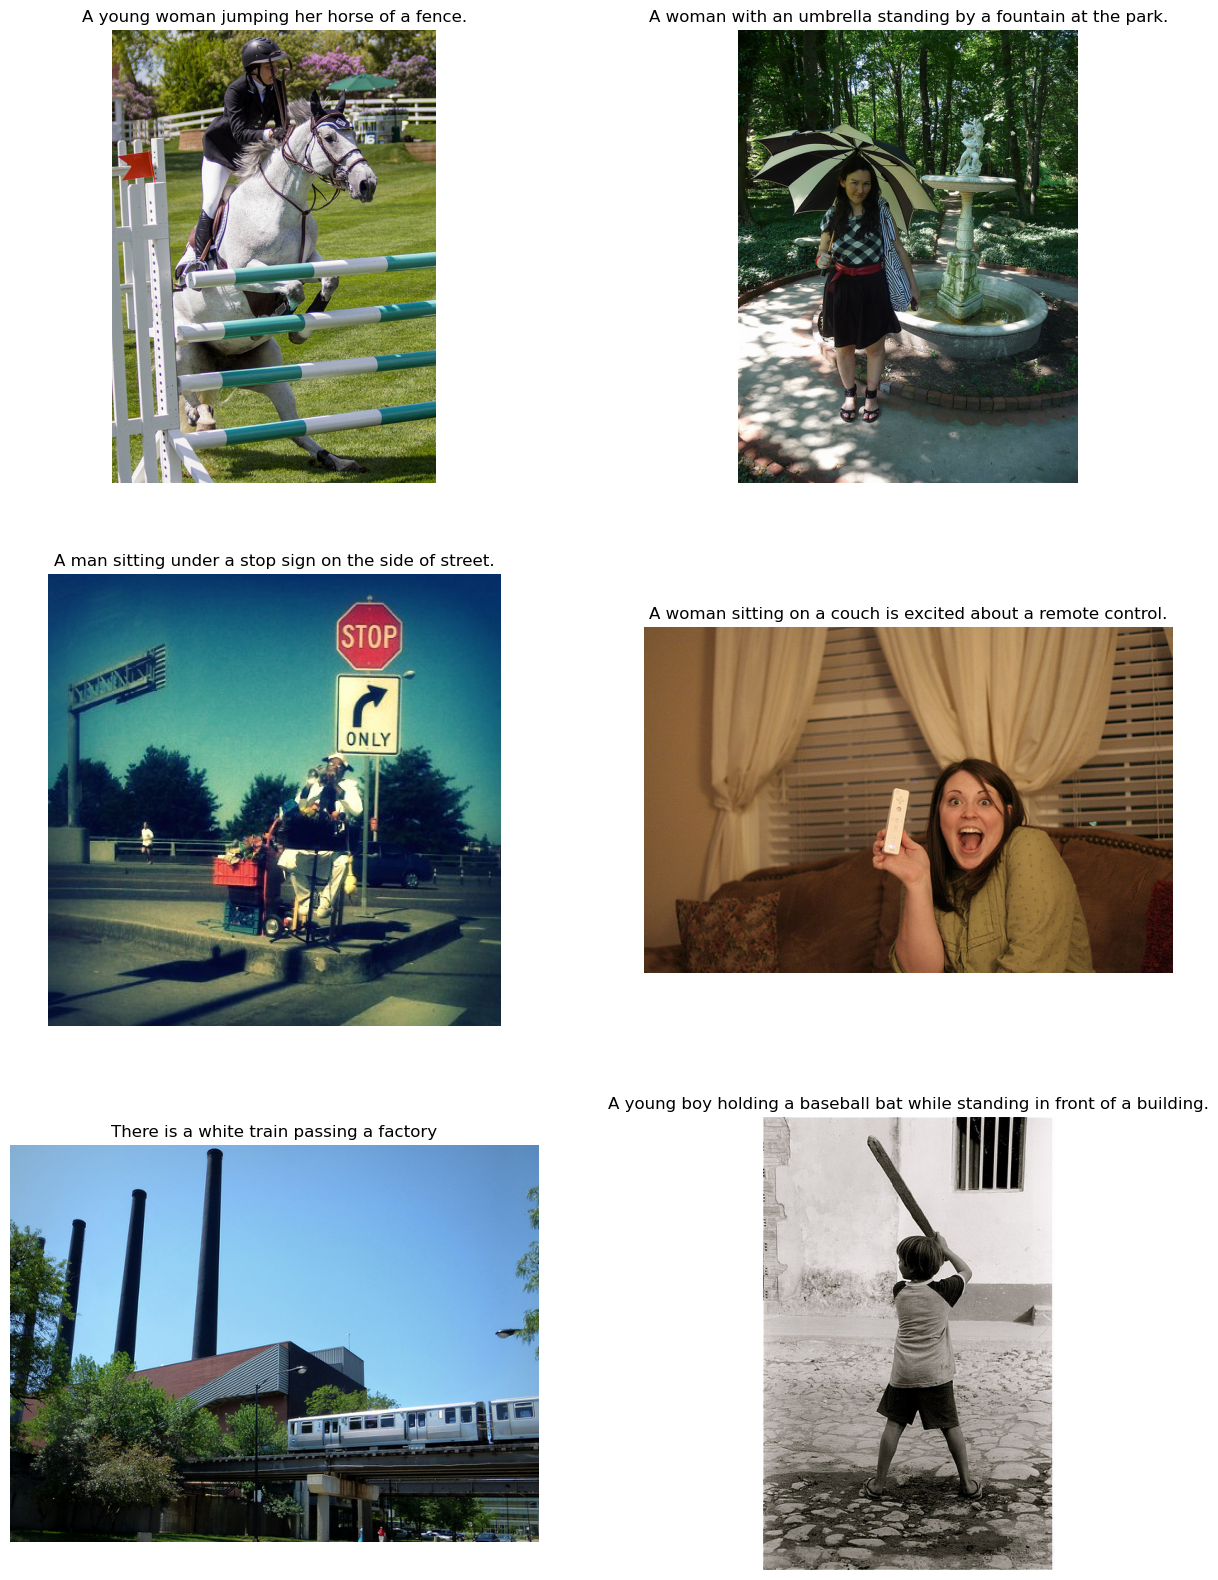

In [9]:
random.seed(1234)

num_samples = 6
index = [random.randint(0,len(all_imgs)) for _ in range(num_samples)]
image_paths =[]
true_captions = []

for i in index:
    image_paths.append(all_imgs[i])
    true_captions.append(all_texts[i])

plt.figure(figsize=(15, 20))
for i, image_path in enumerate(image_paths):
    plt.subplot(num_samples//2, 2, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(true_captions[i])

plt.show()

In [190]:
from collections import Counter
from typing import List

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(texts: List[str], threshold: int) -> Vocabulary:
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        counter.update(tokens)

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    return vocab

vocab = build_vocab(all_texts, threshold=5)
for word in ['boy', 'girl', 'man', 'woman', 'dog', 'cat']:
    print(word, vocab(word))

boy 52
girl 157
man 5
woman 135
dog 116
cat 132


In [191]:
def text_to_sequence(text: str, vocab: Vocabulary) -> List[int]:
    tokens = word_tokenize(text.lower())
    sequence = [vocab('<start>')] + [vocab(token) for token in tokens] + [vocab('<end>')]
    return sequence

def pad_sequences(sequences: List[List[int]], max_len: int) -> List[List[int]]:
    padded_sequences = [seq + [vocab('<pad>')] * (max_len - len(seq)) for seq in sequences]
    return padded_sequences

sequences = [text_to_sequence(text, vocab) for text in all_texts]
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, max_len)

In [11]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "[start] "+data['caption']+" [end]"

    return data

In [12]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['[start] man wearing earphones doing trick on skateboard ramp. [end]',
 '[start] there is surfer wearing body suit riding wave [end]',
 '[start] the teenagers are standing together on the sidewalk. [end]',
 '[start] person jumping off ramp with their snowboard. [end]',
 '[start] two tennis players play game while crowd watches. [end]',
 '[start] laptop next to book opened on floor. [end]',
 '[start] person riding horse on city street near buildings. [end]',
 '[start] small boy in an orange shirt baseball glove and ball [end]',
 '[start] lot of people that are riding some horses. [end]',
 '[start] chocolate cake that has small house and some animals on it. [end]']

In [13]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [14]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[2, 89, 9, 179, 48, 331, 144, 23, 95, 1]

In [15]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 9448/9448 [47:45<00:00,  3.30it/s]  


In [16]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [17]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [18]:
from tensorflow.keras.utils import plot_model


In [19]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [20]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                           
                                           tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [21]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [22]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 5.8042
Epoch 1: val_loss improved from inf to 5.06329, saving model to model.h5
133/133 [==============================] - 107s 776ms/step - loss: 5.8042 - val_loss: 5.0633 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 4.9309
Epoch 2: val_loss improved from 5.06329 to 4.56308, saving model to model.h5
133/133 [==============================] - 99s 742ms/step - loss: 4.9309 - val_loss: 4.5631 - lr: 0.0010
Epoch 3/50
133/133 [==============================] - ETA: 0s - loss: 4.5240
Epoch 3: val_loss improved from 4.56308 to 4.31578, saving model to model.h5
133/133 [==============================] - 99s 745ms/step - loss: 4.5240 - val_loss: 4.3158 - lr: 0.0010
Epoch 4/50
133/133 [==============================] - ETA: 0s - loss: 4.2730
Epoch 4: val_loss improved from 4.31578 to 4.16333, saving model to model.h5
133/133 [==============================] - 98s 738ms/step - loss: 4.2730

In [23]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


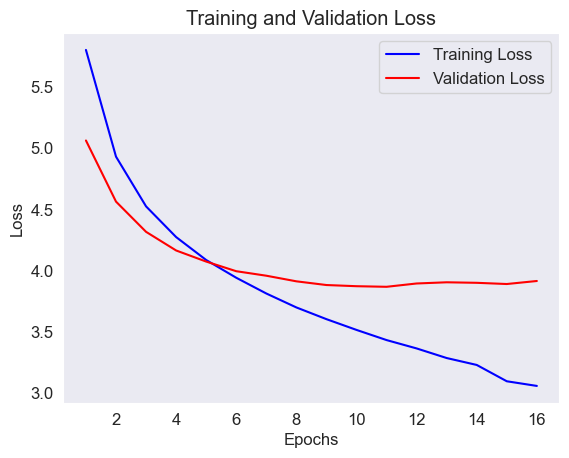

In [24]:
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [25]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
           break
            
    return in_text

In [66]:
samples = test.sample(6)
samples.reset_index(drop=True,inplace=True)

In [67]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 32ms/step


In [74]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))

    for i in range(6):
        plt.subplot(num_samples//2, 2, i + 1)
        #plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title(f"Predicted: {temp_df.caption[i]}")
        plt.axis("off")
    plt.show()

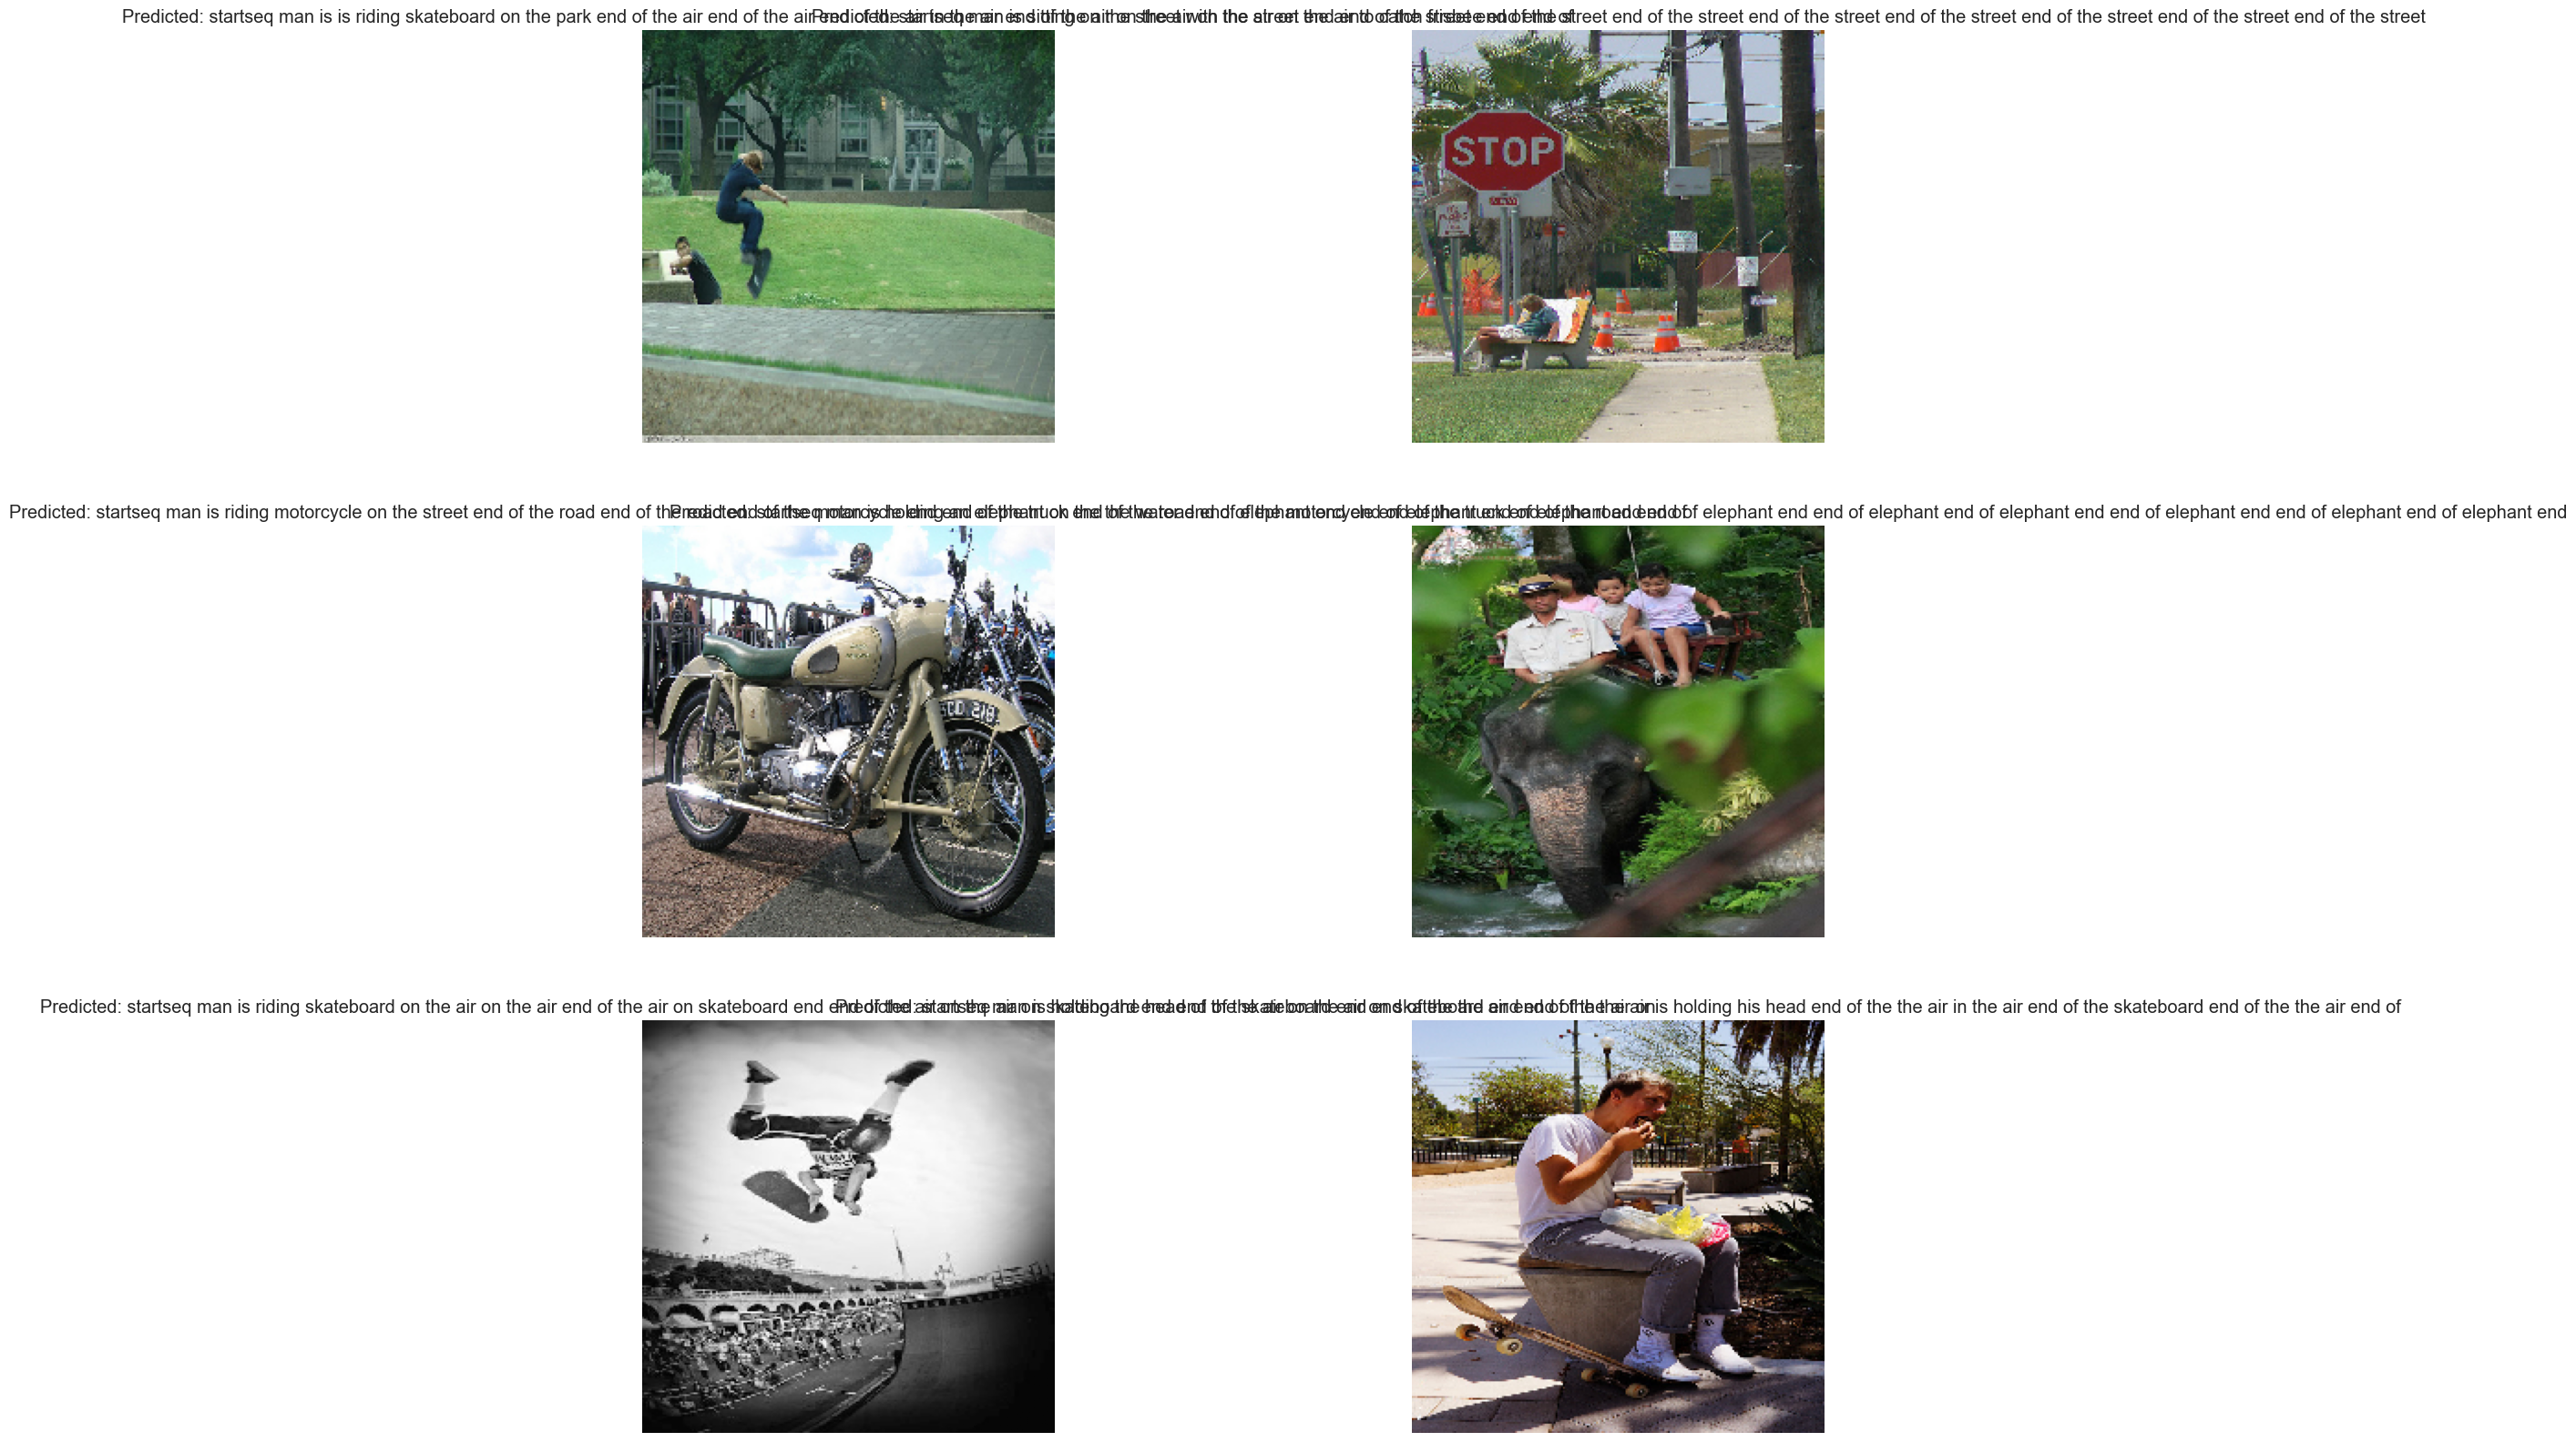

In [75]:
display_images(samples)